This notebook provides a short overview of different molecular representation methods.
Inspired from https://www.rdkit.org/docs/Cookbook.html , https://iwatobipen.wordpress.com/ , https://gist.github.com/greglandrum, https://practicalcheminformatics.blogspot.com/


Install RDKit which is an Open-Source Cheminformatics Software and py3Dmol which is a molecule visualiser.

In [ ]:
#import all the modules needed for running this.
import py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

1.1. Working with SMILES
When we have SMILES string, we can use MolFromSmiles to render the molecule. Keep in mind that the SMILES doesn't contain the atomic coordinates and thus RdKit generates them while drawing the molecules.

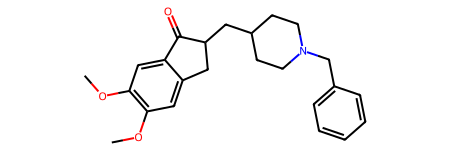

In [ ]:
# drawing structure from a SMILES
donz = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC=C4)OC')
donz

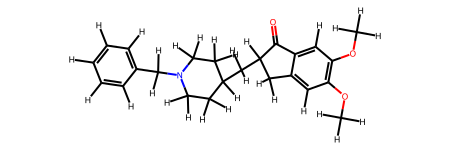

In [ ]:
# Add hydrogens to the structure.
donzH = Chem.AddHs(donz)
donzH

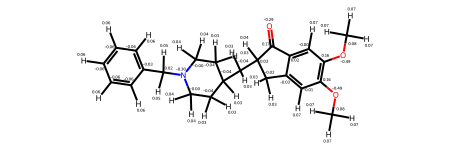

In [ ]:
# Caluculate and display Gasteiger Charges for each atom
AllChem.ComputeGasteigerCharges(donzH)
donzH

donzH_charges = Chem.Mol(donzH)
for at in donzH_charges.GetAtoms():
    lbl = '%.2f'%(at.GetDoubleProp("_GasteigerCharge"))
    at.SetProp('atomNote',lbl)
donzH_charges

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

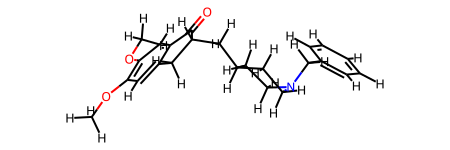

In [ ]:
# Render a molecule in 3D
AllChem.EmbedMolecule(donzH)
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization
donzH

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

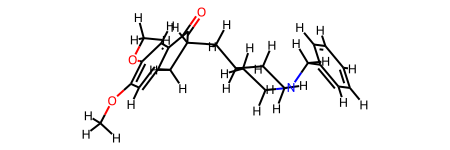

In [ ]:
# Optmise the geometry using MMFF.
AllChem.MMFFOptimizeMolecule(donzH)
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization
donzH

((2, 3, 4, 5, 6, 7), (20, 21, 22, 23, 24, 25))


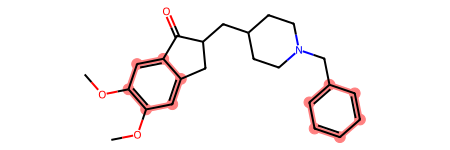

In [ ]:
#Highlighting substructure search

print(donz.GetSubstructMatches(Chem.MolFromSmarts('c1ccccc1')))
donz

In [ ]:
#Download sdf file containing multiple molcules.
!wget https://raw.githubusercontent.com/Rajnishphe/AIDD-2022/main/ML%20Based%20QSAR/example_compounds.sdf


--2025-05-11 08:56:17--  https://raw.githubusercontent.com/Rajnishphe/AIDD-2022/main/ML%20Based%20QSAR/example_compounds.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152641 (149K) [text/plain]
Saving to: ‘example_compounds.sdf.2’

example_compounds.s 100%[===================>] 149.06K  --.-KB/s    in 0.04s   

2025-05-11 08:56:17 (3.81 MB/s) - ‘example_compounds.sdf.2’ saved [152641/152641]



In [ ]:
from rdkit import Chem
from rdkit.Chem import SDMolSupplier

# Load the SDF file
supplier = SDMolSupplier('example_compounds.sdf')

# Extract valid molecules
mols = [mol for mol in supplier if mol is not None]

print(f"Loaded {len(mols)} valid molecules.")


Loaded 50 valid molecules.


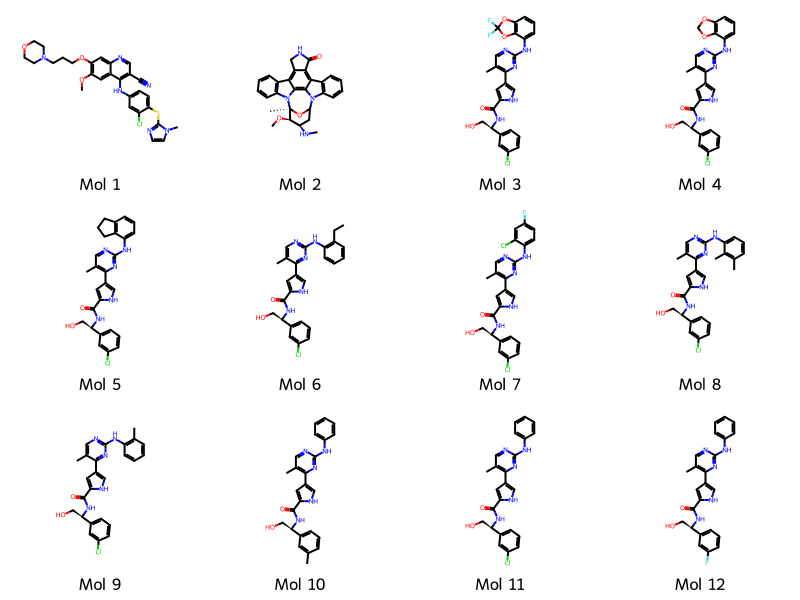

In [ ]:
from rdkit.Chem import Draw

# Optional: show only first N molecules for clarity
n_show = 12
subset_mols = mols[:n_show]

# Generate grid image with molecule indices
img = Draw.MolsToGridImage(
    subset_mols,
    molsPerRow=4,
    subImgSize=(200, 200),
    legends=[f"Mol {i+1}" for i in range(len(subset_mols))],
    useSVG=True  # better rendering in Colab
)

img


In [ ]:
import ipywidgets as widgets
from rdkit.Chem import Draw
from ipywidgets import interactive  # Make sure to import interactive

# Function to display a selected molecule
def display_molecule_with_info(index):
    mol = mols[index]
    name = mol.GetProp('_Name') if mol.HasProp('_Name') else 'No Name'

    # You can add more properties here (e.g., Activity, etc.)
    activity = mol.GetProp('Activity') if mol.HasProp('Activity') else 'N/A'

    img = Draw.MolToImage(mol, size=(300, 300))  # Create molecule image

    # Display molecule information (name and activity)
    print(f"Name: {name}, Activity: {activity}")
    display(img)

# Create the interactive widget with additional information
interactive_widget = interactive(display_molecule_with_info, index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

# Display the widget
interactive_widget


interactive(children=(IntSlider(value=0, description='index', max=49), Output()), _dom_classes=('widget-intera…

In [ ]:
#Generate fingerprints

from rdkit import Chem
from rdkit.Chem import SDMolSupplier, rdFingerprintGenerator
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a fingerprint generator for Morgan fingerprints (radius=2, fpSize=1024)
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

# Generate fingerprints for each molecule in 'mols'
fingerprints = [fpg.GetFingerprint(mol) for mol in mols]

# Convert fingerprints to a binary matrix
fingerprint_matrix = []
for fp in fingerprints:
    arr = np.zeros((1,), dtype=int)
    from rdkit.Chem import DataStructs
    DataStructs.ConvertToNumpyArray(fp, arr)
    fingerprint_matrix.append(arr)

fingerprint_matrix = np.array(fingerprint_matrix)  # Convert list to numpy array



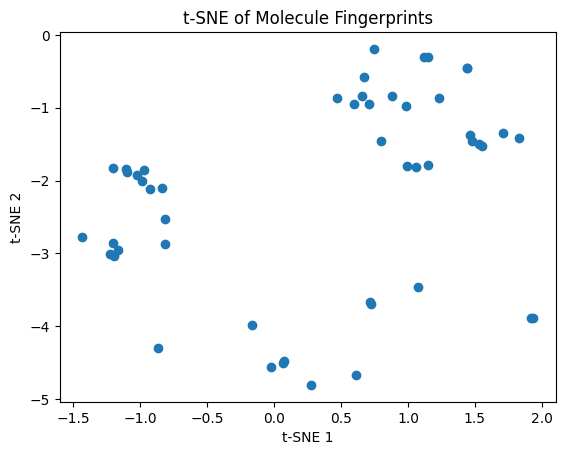

In [ ]:
# Apply t-SNE to reduce the dimensionality of fingerprints to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(fingerprint_matrix)

# Plot the t-SNE result
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Molecule Fingerprints')
plt.show()


In [ ]:
#Download a csv file

!wget https://raw.githubusercontent.com/Rajnishphe/AIDD-2022/main/ML%20Based%20QSAR/new_1.csv


--2025-05-11 08:56:18--  https://raw.githubusercontent.com/Rajnishphe/AIDD-2022/main/ML%20Based%20QSAR/new_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3561 (3.5K) [text/plain]
Saving to: ‘new_1.csv.1’

new_1.csv.1         100%[===================>]   3.48K  --.-KB/s    in 0s      

2025-05-11 08:56:18 (43.2 MB/s) - ‘new_1.csv.1’ saved [3561/3561]



In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('new_1.csv')

# Display the first few rows of the DataFrame
df.head()


,Ambit_InchiKey,score,activity,SMILES
0,PFNFFQXMRSDOHW-UHFFFAOYNA-N,1,Active,N(CCCCNCCCN)CCCN
1,HOTSFPXUILMJMT-UHFFFAOYNA-N,1,Active,OC(CNC=1C=CC=CC1)COC
2,IEUAZNHOIZPQER-UHFFFAOYNA-N,1,Active,O1C2(NC(C1)(CO)CO)CCCC2
3,NZPYFPLXCCGDDX-UHFFFAOYNA-N,1,Active,ClC=1C(C=2C=CN=CC2)=CSC1N
4,XMYZXGRJFKLGLI-UHFFFAOYNA-N,1,Active,O=C(N1CC(CCC1)C)CCCC


/usr/local/lib/python3.11/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


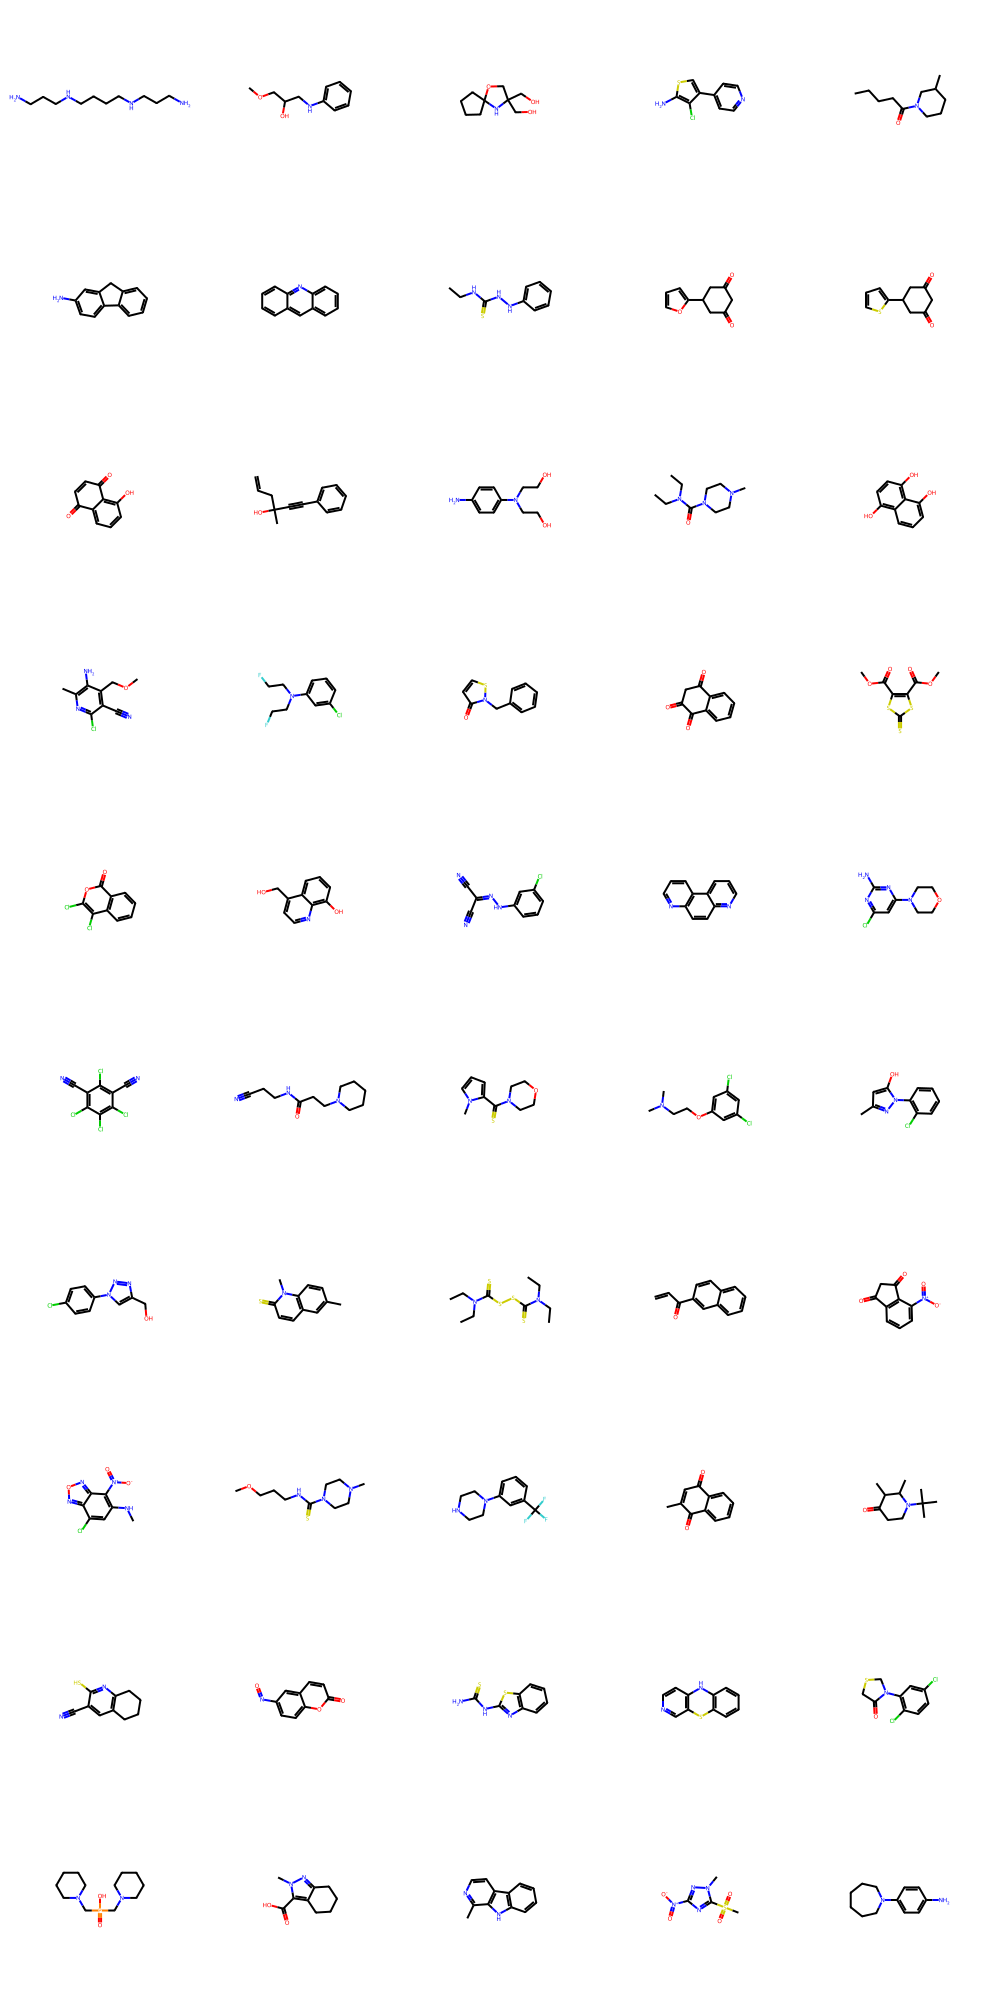

In [ ]:
#Convert SMILES column into RDKit molecule objects
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# Vizualize the molecules in a grid
# Display molecules in a grid (e.g., 5 molecules per row)
img = Draw.MolsToGridImage(df['Mol'].dropna(), molsPerRow=5, subImgSize=(200, 200))

# Display the grid image
img

In [ ]:
!ls

example_compounds.sdf	 example_compounds.sdf.2  new_1.csv.1
example_compounds.sdf.1  new_1.csv		  sample_data


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Load the CSV file into a DataFrame
df = pd.read_csv('new_1.csv')

# Step 2: Convert SMILES column into RDKit molecule objects
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# Step 3: Calculate molecular descriptors and add them to the DataFrame
# List of descriptor functions to apply (you can add more descriptors as needed)
descriptors = {
    'MolWt': Descriptors.MolWt,
    'LogP': Descriptors.MolLogP,
    'TPSA': Descriptors.TPSA,
    'NumHDonors': Descriptors.NumHDonors,
    'NumHAcceptors': Descriptors.NumHAcceptors
}

# Calculate descriptors and add them as new columns in the DataFrame
for descriptor_name, descriptor_function in descriptors.items():
    df[descriptor_name] = df['Mol'].apply(lambda mol: descriptor_function(mol) if mol is not None else None)

# Display the updated DataFrame with descriptors
df.head()


,Ambit_InchiKey,score,activity,SMILES,Mol,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors
0,PFNFFQXMRSDOHW-UHFFFAOYNA-N,1,Active,N(CCCCNCCCN)CCCN,<rdkit.Chem.rdchem.Mol object at 0x7ce3b5420c10>,202.346,-0.3566,76.10,4,4
1,HOTSFPXUILMJMT-UHFFFAOYNA-N,1,Active,OC(CNC=1C=CC=CC1)COC,<rdkit.Chem.rdchem.Mol object at 0x7ce3b5420ba0>,181.235,1.1058,41.49,2,3
2,IEUAZNHOIZPQER-UHFFFAOYNA-N,1,Active,O1C2(NC(C1)(CO)CO)CCCC2,<rdkit.Chem.rdchem.Mol object at 0x7ce3b5420e40>,187.239,-0.4001,61.72,3,4
3,NZPYFPLXCCGDDX-UHFFFAOYNA-N,1,Active,ClC=1C(C=2C=CN=CC2)=CSC1N,<rdkit.Chem.rdchem.Mol object at 0x7ce3b5420eb0>,210.689,3.0457,38.91,1,3
4,XMYZXGRJFKLGLI-UHFFFAOYNA-N,1,Active,O=C(N1CC(CCC1)C)CCCC,<rdkit.Chem.rdchem.Mol object at 0x7ce3b5420f20>,183.295,2.4351,20.31,0,1


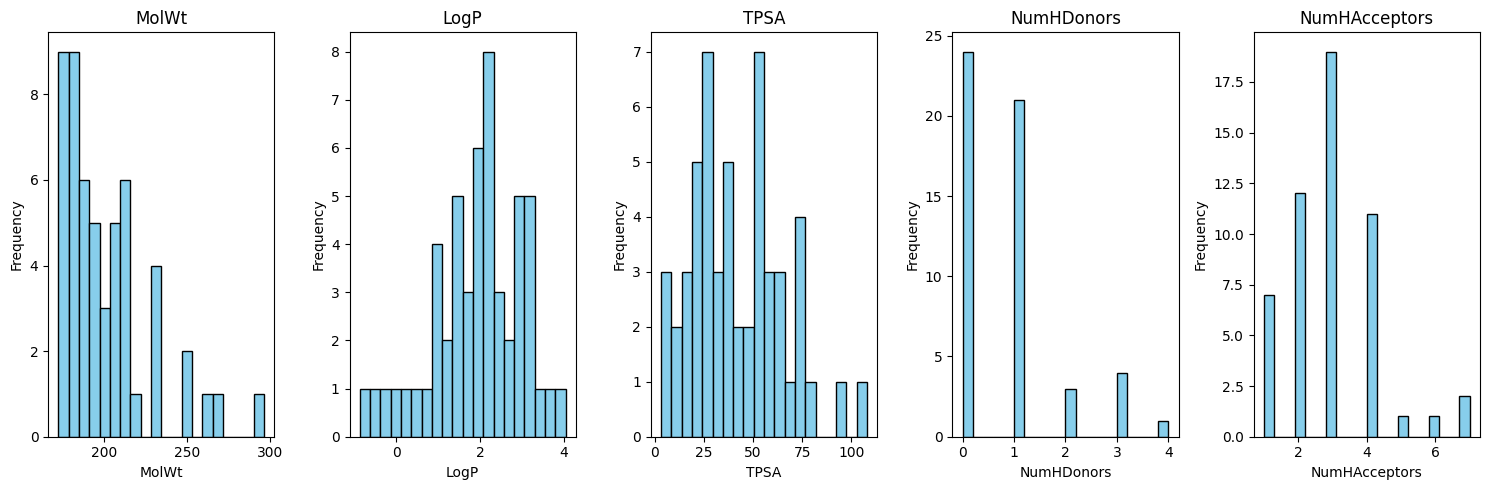

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the descriptors are already calculated and stored in the DataFrame 'df'

# Define the descriptors to plot
descriptors = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors']

# Create a subplot with multiple plots for each descriptor
fig, ax = plt.subplots(1, len(descriptors), figsize=(15, 5))

# Iterate over descriptors and plot
for i, descriptor in enumerate(descriptors):
    ax[i].hist(df[descriptor].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax[i].set_title(descriptor)
    ax[i].set_xlabel(descriptor)
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


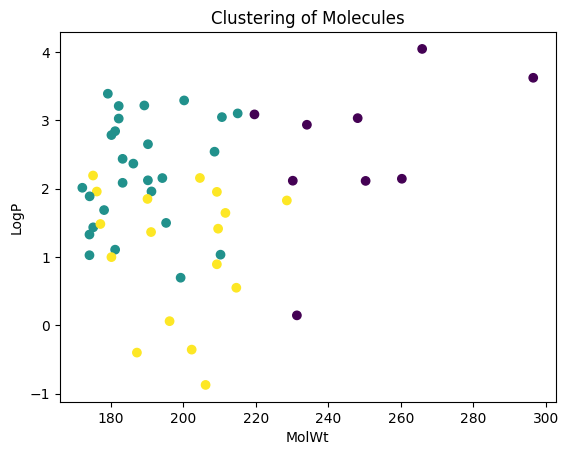

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting relevant columns (descriptors) for clustering
df_cluster = df[['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_cluster)

# Plot clusters
plt.scatter(df['MolWt'], df['LogP'], c=df['Cluster'], cmap='viridis')
plt.xlabel('MolWt')
plt.ylabel('LogP')
plt.title('Clustering of Molecules')
plt.show()


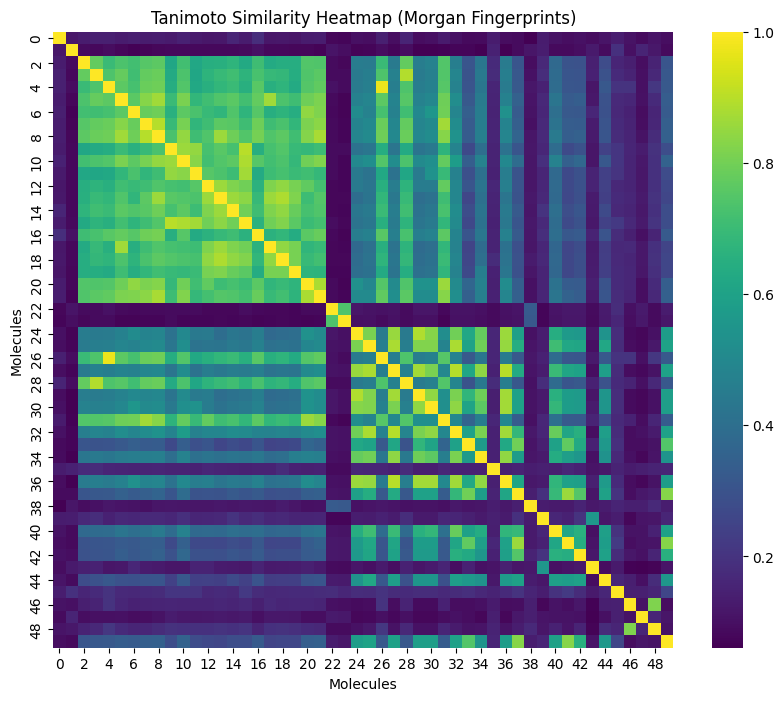

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.DataStructs import TanimotoSimilarity

# Compute similarity matrix
n = len(fingerprints)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = TanimotoSimilarity(fingerprints[i], fingerprints[j])

# Plot similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Tanimoto Similarity Heatmap (Morgan Fingerprints)")
plt.xlabel("Molecules")
plt.ylabel("Molecules")
plt.show()


1.2. Reading a molfile

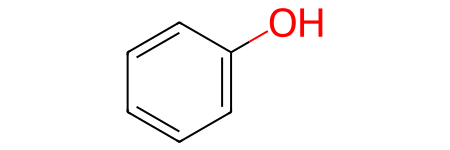

In [ ]:
molblock = """phenol
  Mrv1682210081607082D

  7  7  0  0  0  0            999 V2000
   -0.6473    1.0929    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3618    0.6804    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3618   -0.1447    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6473   -0.5572    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0671   -0.1447    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0671    0.6804    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7816    1.0929    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  2  3  2  0  0  0  0
  3  4  1  0  0  0  0
  4  5  2  0  0  0  0
  5  6  1  0  0  0  0
  1  6  2  0  0  0  0
  6  7  1  0  0  0  0
M  END
"""
m = Chem.MolFromMolBlock(molblock)
m

[08:56:20] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

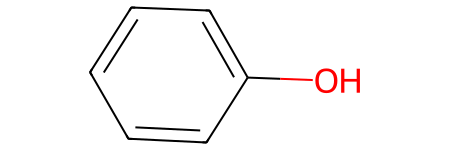

In [ ]:
# Render a molecule in 3D
AllChem.EmbedMolecule(m)
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization
m

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

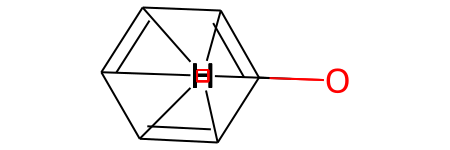

In [ ]:
# Add hydrigens to the structure.
mH = Chem.AddHs(m)
mH

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

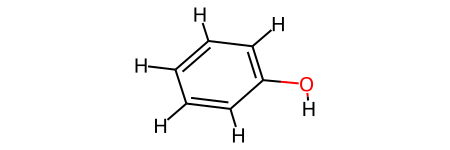

In [ ]:
# Optimise the geometry to generate low energy structure.
AllChem.MMFFOptimizeMolecule(mH)
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization
mH

1.3. Reading a PDB file (Protein data bank)

In [ ]:
viewer = py3Dmol.view(query='pdb:1EVE')
viewer.setStyle({'cartoon':{'color': 'spectrum'}})
#viewer.addSurface(py3Dmol.VDW,{'opacity':0.9,'color':'white'})

# select by distance
selection = {'resn':'E20', 'chain':'A', 'byres':'true', 'expand': 5}

# set styles
viewer.setStyle(selection,{'stick':{'colorscheme':'orangeCarbon'}})
viewer.setStyle({'resn': 'E20'},{'stick': {'colorscheme': 'greenCarbon'}})
viewer.zoomTo(selection)
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.